In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import random

In [49]:
# 生成测试数据
def generate_test_data(file_path, num_of_pair):
    x = np.random.rand(num_of_pair, 1) * 2
    y = 2 * x + np.random.rand(num_of_pair, 1)
    np.savetxt(file_path, np.concatenate((x, y), axis=1), delimiter=',')

generate_test_data('data.csv', 100)

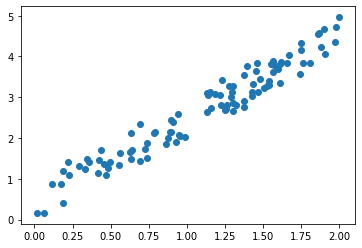

In [4]:
data = np.genfromtxt('data.csv', delimiter=',')
xs = data[:,0]
ys = data[:,1]

plt.scatter(xs, ys)
plt.show()

In [5]:
# 使用 numpy 形式求解相关系数
def compute_corrcoef(xs, ys):
    return np.dot((xs - np.average(xs)), (ys - np.average(ys))) / np.sqrt(np.dot((xs - np.average(xs)) ** 2, (ys - np.average(ys)) ** 2))

print(compute_corrcoef(xs, ys))

# 使用循环的形式求解相关系数
def compute_corrcoef2(xs, ys):
    up = 0
    down = 0
    avg_x = np.average(xs)
    avg_y = np.average(ys)

    for i in range(len(xs)):
        up += (xs[i] - avg_x) * (ys[i] - avg_y)
        down += (xs[i] - avg_x)**2 * (ys[i] - avg_y)**2

    return (up / np.sqrt(down))

print(compute_corrcoef2(xs, ys))

6.886744903906882
6.886744903906884


In [6]:
# 计算误差平方差
def compute_error(data, k, b):
    predict_ys = k * data[:,0] + b
    ys = data[:,1]
    return sum((predict_ys - ys) **2 / len(data) / 2)
    
print(compute_error(data, 0, 0))

4.193734758832075


In [7]:
def gradient_descent(data, k, b, lr, epochs):
    xs = data[:,0]
    ys = data[:,1]
    m = len(data)
    for i in range(epochs):
        delta_b = 0
        delta_k = 0

        for j in range(m):
            delta_b += 1/ m * (k * xs[j] + b - ys[j])
            delta_k += 1 / m * (k * xs[j] + b - ys[j]) * xs[j]

        b = b - lr * delta_b
        k = k - lr * delta_k

    return k, b

gradient_descent(data, 0, 0, 0.1, 50)

(1.716340079023243, 0.8341701795623296)

k=0, b=0, epochs=50, error=4.193734758832075
after 50 epochs, k=2.0463073116321038, b=0.4230538158337416, error=0.0375692036256948


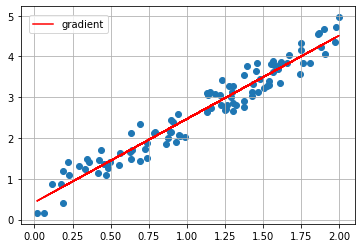

In [9]:
# 使用最小二乘法求解一元线性回归
k = 0
b = 0
lr = 0.75
epochs = 50

print('k={0}, b={1}, epochs={2}, error={3}'.format(k, b, epochs, compute_error(data, k, b)))

k, b = gradient_descent(data, k, b, lr, 100)
print('after {0} epochs, k={1}, b={2}, error={3}'.format(epochs, k, b, compute_error(data, k, b)))
plt.scatter(xs, ys)
plt.plot(xs, k * xs + b, 'r', label='gradient')

plt.grid(True)
plt.legend(bbox_to_anchor=(0.26, 0.96), loc=1, borderaxespad=0.)
plt.show()

In [10]:
# 使用 PRO 进化算法求解
class Solution(object):
    # 当解向量连续 C 次级别最低，则需要重新生成
    C = 3
    # 级别列表
    TAGS = ['S', 'A', 'B']
    TAGS_LEN = 3

    def __init__(self, vector, fitness):
        # 用于保存历史记录中最优的和次优的
        # 两个均为列表，第一项为适应值，第二项为解向量
        self.bestVector = None
        self.betterVector = None
        
        # 当前的解向量
        self.currentVector = vector
        # 当前的适应值
        self.fitness = fitness
        self.tags = []

    def set_tag(self, tag):
        if len(self.tags) == Solution.C:
            self.tags.pop(0)
        self.tags.append(tag)
        
    def empty_tag(self):
        self.tags = []
        return self
        
    def is_unused(self):
        tags = list(set(self.tags))
        # 当标签列表的长度为指定 C 后，表示该解向量已连续 C 次评级
        # 当标签列表去重后，只剩下一个元素
        # 若该元素为最低级别，则表示该解向量需要重新生成
        # print(len(tags), len(self.tags) == Solution.C, len(tags) == 1 , tags[0] == Solution.TAGS[Solution.TAGS_LEN - 1])
        if len(self.tags) == Solution.C and len(tags) == 1 and tags[0] == Solution.TAGS[Solution.TAGS_LEN - 1]:
            return True
        return False

    def renew(self, vector, fitness):
        # 当考核过后，需要重新生成，则调用该方法
        l = [
            self.bestVector,
            self.betterVector,
            [self.fitness, self.currentVector]
        ]
        # 对 l 按适应值从小到大排序
        l = sorted(l, key=lambda x:x[0])
        self.bestVector = l[0]
        self.betterVector = l[1]
        self.empty_tag()
        self.currentVector = vector
        self.fitness = fitness

    def first(self):
        # 当第一次创建时，历史最优和次优为当前向量
        self.bestVector = [self.fitness, self.currentVector]
        self.betterVector = [self.fitness, self.currentVector]
        return self

In [11]:
class Population(object):
    def __init__(self, N, D, U, L, learnRates, learnRateSelf, fitnessFunc):
        self.N = N
        self.D = D
        self.U = U
        self.L = L
        self.learnRates = learnRates
        self.learnRateSelf = learnRateSelf
        self.fitnessFunc = fitnessFunc
        self.solutions = []
        self.groupSize = int(self.N / Solution.TAGS_LEN)
        self.rate_after_hook = lambda x: x

    def initial(self):
        # 初始化种群
        self.solutions = [Solution(*self.create_vector()).first() for i in range(self.N)]

    def rate(self):
        # 考核阶段
        self.solutions = sorted(self.solutions, key=lambda x:x.fitness)
        # 为所有解向量进行评级
        for i in range(self.N):
            self.solutions[i].set_tag(Solution.TAGS[int(i / (N / Solution.TAGS_LEN))])
            # 当向量连续 C 次评级最差，则需要重新生解向量
            # print(self.solutions[i].is_unused())
            if self.solutions[i].is_unused():
                
                self.solutions[i] = copy.copy(self.solutions[i - self.groupSize * 2])
                self.solutions[i].empty_tag()

        # for i in range(self.N):
        #     if self.solutions[i].is_unused():
        #         self.solutions[i].renew(*self.create_vector())

    def learn(self):
        # 学习阶段
        # self.solutions = sorted(self.solutions, key=lambda x:x.fitness)
        learnRates = [x.next() for x in self.learnRates]

        for i in range(len(self.learnRates)):
            for j in range(self.groupSize):
                index = (i + 1) * self.groupSize + j
                solution = copy.copy(self.solutions[index])
                currentVector = solution.currentVector
                newVector = currentVector

                # 使用 for 循环得到新的测试解向量
                for k in range(i + 1):
                    flag = 1 if np.random.rand() > 0.5 else -1
                    priorBetterVector = self.solutions[k * self.groupSize].currentVector
                    newVector = newVector + flag * learnRates[k] * (priorBetterVector - currentVector)
                
                newVector, newFitness = self.check_vector(newVector)

                if newFitness < solution.fitness:
                    self.solutions[index].renew(vector=newVector, fitness=newFitness)
    
    def promote(self):
        # self.solutions = sorted(self.solutions, key=lambda x:x.fitness)
        learnRate = self.learnRateSelf.next()

        for i in range(Solution.TAGS_LEN):
            groupStartIndex = i * self.groupSize
            groupEndIndex = (i + 1) * self.groupSize
            groupFitnessSum = sum([s.fitness for s in self.solutions[groupStartIndex:groupEndIndex]])
            probabilities = [s.fitness / groupFitnessSum for s in self.solutions[groupStartIndex:groupEndIndex]]

            for j in range(groupStartIndex, groupEndIndex):
                solution = copy.copy(p.solutions[j])
                newVector = solution.currentVector
                index = random.choices(list(range(groupStartIndex, groupEndIndex)), probabilities)[0]
                flag = 1 if np.random.rand() > 0.5 else -1

                newVector = newVector + flag * learnRate * (p.solutions[j].currentVector - p.solutions[index].currentVector)
                newVector, newFitness = self.check_vector(newVector)

                if newFitness < solution.fitness:
                    self.solutions[index].renew(vector=newVector, fitness=newFitness)

        

    @staticmethod
    def vector_unit_opt(x, y, p):
        return (x - y) * p

    def check_vector(self, vector):
        # 用于检查解向量是否过界
        # 过界则直接设置为边界值
        for i in range(self.D):
            if vector[i] > U[i]:
                vector[i] = U[i]
            if vector[i] < L[i]:
                vector[i] = L[i]
        return vector, self.fitnessFunc(vector)

    def create_vector(self):
        # 解向量的每一个分量都应该乘以服从 U(0, 1) 的随机数
        vector = L + np.matmul(np.diag(np.random.uniform(0, 1, self.D)), U - L)
        fitness = self.fitnessFunc(vector)
        return vector, fitness

In [12]:
class Param(object):
    def __init__(self, param_range, T):
        self.param_range = param_range
        self.t = 0
        self.T = T

    def next(self):
        self.t += 1
        return self.param_range[0] + (self.param_range[1] - self.param_range[0]) * (2 - math.exp((self.t / self.T) * math.log(2)))

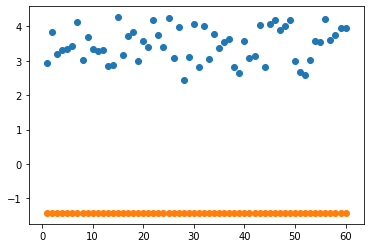

In [13]:
T = 3000 # 最大迭代次数
N = 60 # 种群的大小
D = 2 # 解向量的维数
U = np.array([100] * D)
L = np.array([-100] * D)
F1 = Param([0.0, 0.5], T)
G1 = Param([0.0, 0.2], T)
R1 = Param([0.0, 0.9], T)

def fitnessFunc(xs):
    predict_ys = xs[0] * data[:,0] + xs[1]
    ys = data[:,1]
    return sum((predict_ys - ys) **2 / len(data) / 2)

p = Population(N, D, U, L, [F1, G1], R1, fitnessFunc)
topFitness = []

p.initial()
plt.scatter(list(range(1, N+1)), [math.log(s.fitness, 10) for s in p.solutions])
for i in range(T):
    p.rate()
    p.learn()
    p.promote()
    topFitness.append(p.solutions[0].fitness)

plt.scatter(list(range(1, N+1)), [math.log(s.fitness, 10) for s in p.solutions])
plt.show()

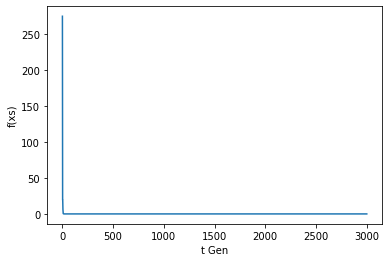

In [22]:
plt.plot(list(range(1, T + 1)), [f for f in topFitness])
plt.xlabel('t Gen')
plt.ylabel('f(xs)')
plt.show()

k=2.0463670424960716, b=0.42297939363438514, error=0.03756920309169697


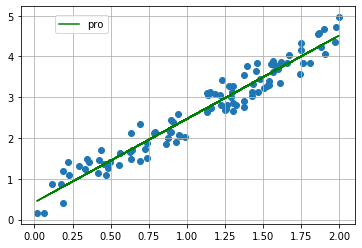

In [16]:
k, b = p.solutions[0].currentVector
plt.scatter(xs, ys)
plt.plot(xs, k * xs + b, 'g', label='pro')
print('k={0}, b={1}, error={2}'.format(k, b, compute_error(data, k, b)))

plt.grid(True)
plt.legend(bbox_to_anchor=(0.26, 0.96), loc=1, borderaxespad=0.)
plt.show()
# k=2.0463073116321038, b=0.4230538158337416, error=0.0375692036256948
# k=2.0463670418783697, b=0.4229793940911577, error=0.03756920309169697

k=0, b=0, epochs=50, error=4.193734758832075
after 50 epochs, k=2.0463073116321038, b=0.4230538158337416, error=0.0375692036256948


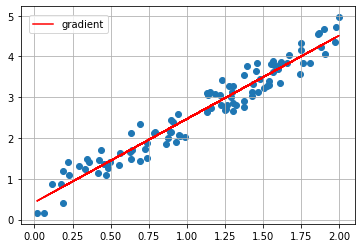

In [19]:
# 使用最小二乘法求解一元线性回归
k = 0
b = 0
lr = 0.75
epochs = 50

print('k={0}, b={1}, epochs={2}, error={3}'.format(k, b, epochs, compute_error(data, k, b)))

k, b = gradient_descent(data, k, b, lr, 100)
print('after {0} epochs, k={1}, b={2}, error={3}'.format(epochs, k, b, compute_error(data, k, b)))
plt.scatter(xs, ys)
plt.plot(xs, k * xs + b, 'r', label='gradient')
plt.grid(True)
plt.legend(bbox_to_anchor=(0.26, 0.96), loc=1, borderaxespad=0.)
plt.show()

k=0, b=0, epochs=50, error=4.193734758832075
after 50 epochs, k=2.0463073116321038, b=0.4230538158337416, error=0.0375692036256948
use pro k=2.0463670424960716, b=0.42297939363438514, error=0.03756920309169697


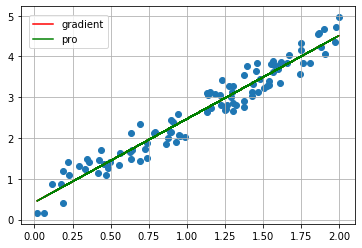

In [18]:


# 使用最小二乘法求解一元线性回归
k = 0
b = 0
lr = 0.75
epochs = 50

print('k={0}, b={1}, epochs={2}, error={3}'.format(k, b, epochs, compute_error(data, k, b)))

k, b = gradient_descent(data, k, b, lr, 100)
print('after {0} epochs, k={1}, b={2}, error={3}'.format(epochs, k, b, compute_error(data, k, b)))
plt.scatter(xs, ys)
plt.plot(xs, k * xs + b, 'r', label='gradient')

# 使用 PRO 进化算法求解
k, b = p.solutions[0].currentVector
plt.plot(xs, k * xs + b, 'g', label='pro')

print('use pro k={0}, b={1}, error={2}'.format(k, b, compute_error(data, k, b)))

plt.grid(True)
plt.legend(bbox_to_anchor=(0.26, 0.96), loc=1, borderaxespad=0.)
plt.show()

In [56]:
a = np.random.rand(10, 1)
b = a ** 2
print(a, b)

[[0.35656315]
 [0.43264218]
 [0.81406059]
 [0.21219184]
 [0.19690465]
 [0.5274985 ]
 [0.29608955]
 [0.19464113]
 [0.15297821]
 [0.59750653]] [[0.12713728]
 [0.18717926]
 [0.66269465]
 [0.04502538]
 [0.03877144]
 [0.27825466]
 [0.08766902]
 [0.03788517]
 [0.02340233]
 [0.35701405]]


In [174]:
a = np.random.rand(2)
b = np.random.rand(2)
print(a)
print(b)
print(np.dot(a, b))


[0.67253097 0.45269511]
[0.90779442 0.45547921]
0.816713069702399


In [170]:
print(sum(a * b)[0])
print(np.dot(a, b))

0.4239031718941317
[[0.12254484]
 [0.30135833]]
